## Import library

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./data"))

2024-03-12 21:02:03.050502: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['.DS_Store', 'test', 'train']


## Define constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare training data

In [4]:
filenames = os.listdir("./data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head(10)

filename  category
0   dog.8011.jpg         1
1   cat.5077.jpg         0
2   dog.7322.jpg         1
3   cat.2718.jpg         0
4  cat.10151.jpg         0
5   cat.3406.jpg         0
6   dog.1753.jpg         1
7   cat.4369.jpg         0
8   cat.7660.jpg         0
9   dog.5535.jpg         1

### See total in count

<Axes: xlabel='category'>

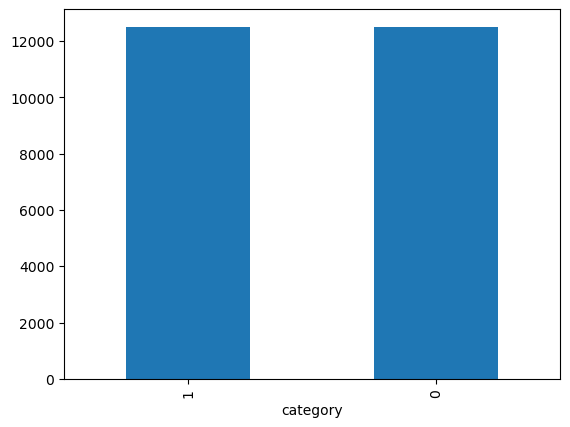

In [6]:
df['category'].value_counts().plot.bar()

### See sample image

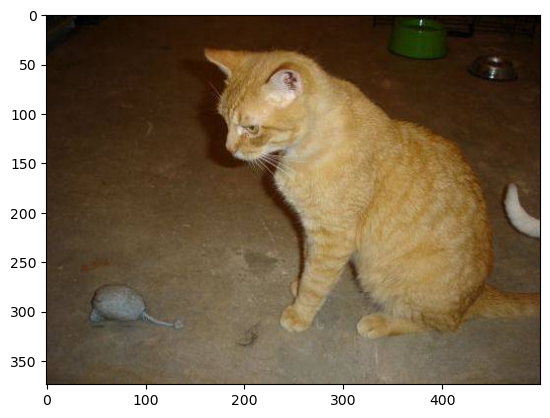

In [7]:
sample = random.choice(filenames)
image = load_img("./data/train/"+sample)
plt.imshow(image)

## Build Model

### Import layer from keras

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.metrics import CategoricalAccuracy

In [9]:
model = Sequential()

# First layer 
model.add(Conv2D(filters=32, 
                 kernel_size=(3,3), 
                 activation='relu', 
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25))

# 2nd layer
model.add(Conv2D(filters=64, 
                 kernel_size=(3,3), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25))

# 3rd layer
model.add(Conv2D(filters=128, 
                 kernel_size=(3,3), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25))

# 4th layer
model.add(Conv2D(filters=256, 
                 kernel_size=(3,3), 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25))

# Classifier
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes


In [10]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[CategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

## Callbacks

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

##### Early Stop

To prevent over fitting I will stop the learning after 10 epochs and val_loss value not decreased

In [12]:
earlystop = EarlyStopping(patience=10)

##### Learning Rate Reduction

I will reduce the learning rate when then accuracy not increase for 2 steps

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [14]:
callbacks = [earlystop, learning_rate_reduction]

## Prepare data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat



In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [17]:
train_number = train_df.shape[0]
validate_number = validate_df.shape[0]
batch_size = 15

## Create generator

In [18]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 20000 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


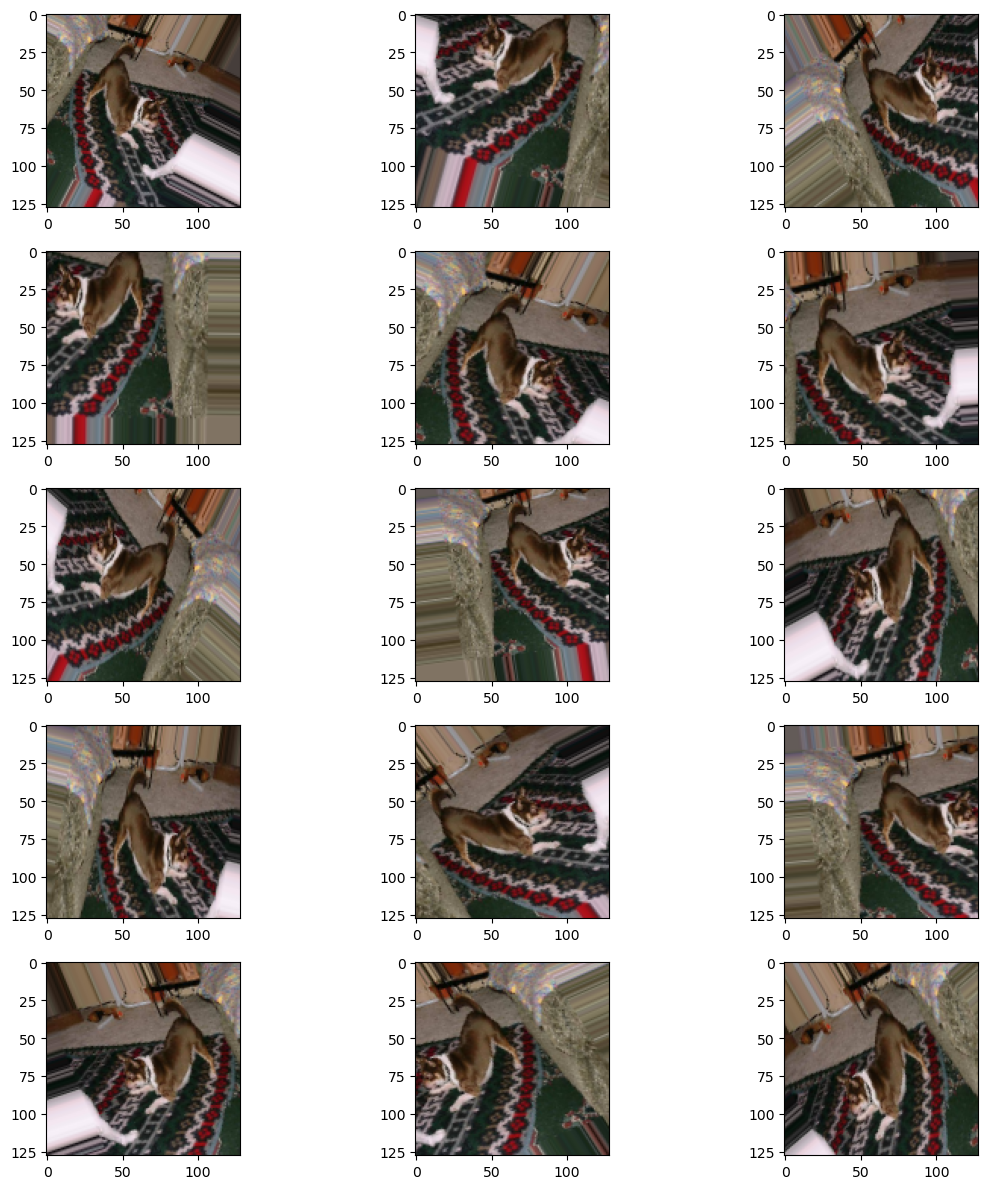

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [22]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validate_number//batch_size,
    steps_per_epoch=train_number//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 452s 338ms/step - loss: 0.7870 - categorical_accuracy: 0.5914 - val_loss: 0.6013 - val_categorical_accuracy: 0.6623 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 453s 340ms/step - loss: 0.6172 - categorical_accuracy: 0.6711 - val_loss: 0.5436 - val_categorical_accuracy: 0.7429 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 456s 342ms/step - loss: 0.5698 - categorical_accuracy: 0.7097 - val_loss: 0.6326 - val_categorical_accuracy: 0.6965 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5333 - categorical_accuracy: 0.7412
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 477s 358ms/step - loss: 0.5333 - categorical_accuracy: 0.7412 - val_loss: 0.9183 - val_categorical_accuracy: 0.6250 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 483s 362ms/step - loss: 0.468

Epoch 38/50
1333/1333 [==============================] - 456s 342ms/step - loss: 0.2965 - categorical_accuracy: 0.8741 - val_loss: 0.1812 - val_categorical_accuracy: 0.9285 - lr: 1.0000e-05
Epoch 39/50
1333/1333 [==============================] - 476s 357ms/step - loss: 0.2892 - categorical_accuracy: 0.8766 - val_loss: 0.1835 - val_categorical_accuracy: 0.9275 - lr: 1.0000e-05
Epoch 40/50
1333/1333 [==============================] - 438s 328ms/step - loss: 0.2915 - categorical_accuracy: 0.8767 - val_loss: 0.1788 - val_categorical_accuracy: 0.9293 - lr: 1.0000e-05
Epoch 41/50
1333/1333 [==============================] - 438s 328ms/step - loss: 0.2953 - categorical_accuracy: 0.8725 - val_loss: 0.1783 - val_categorical_accuracy: 0.9283 - lr: 1.0000e-05
Epoch 42/50
1333/1333 [==============================] - 447s 335ms/step - loss: 0.2884 - categorical_accuracy: 0.8753 - val_loss: 0.1811 - val_categorical_accuracy: 0.9279 - lr: 1.0000e-05
Epoch 43/50
1333/1333 [===========================

## Save model

In [25]:
model.save_weights("model.h5")
model.save("my_model.keras")

## Virtualize Training

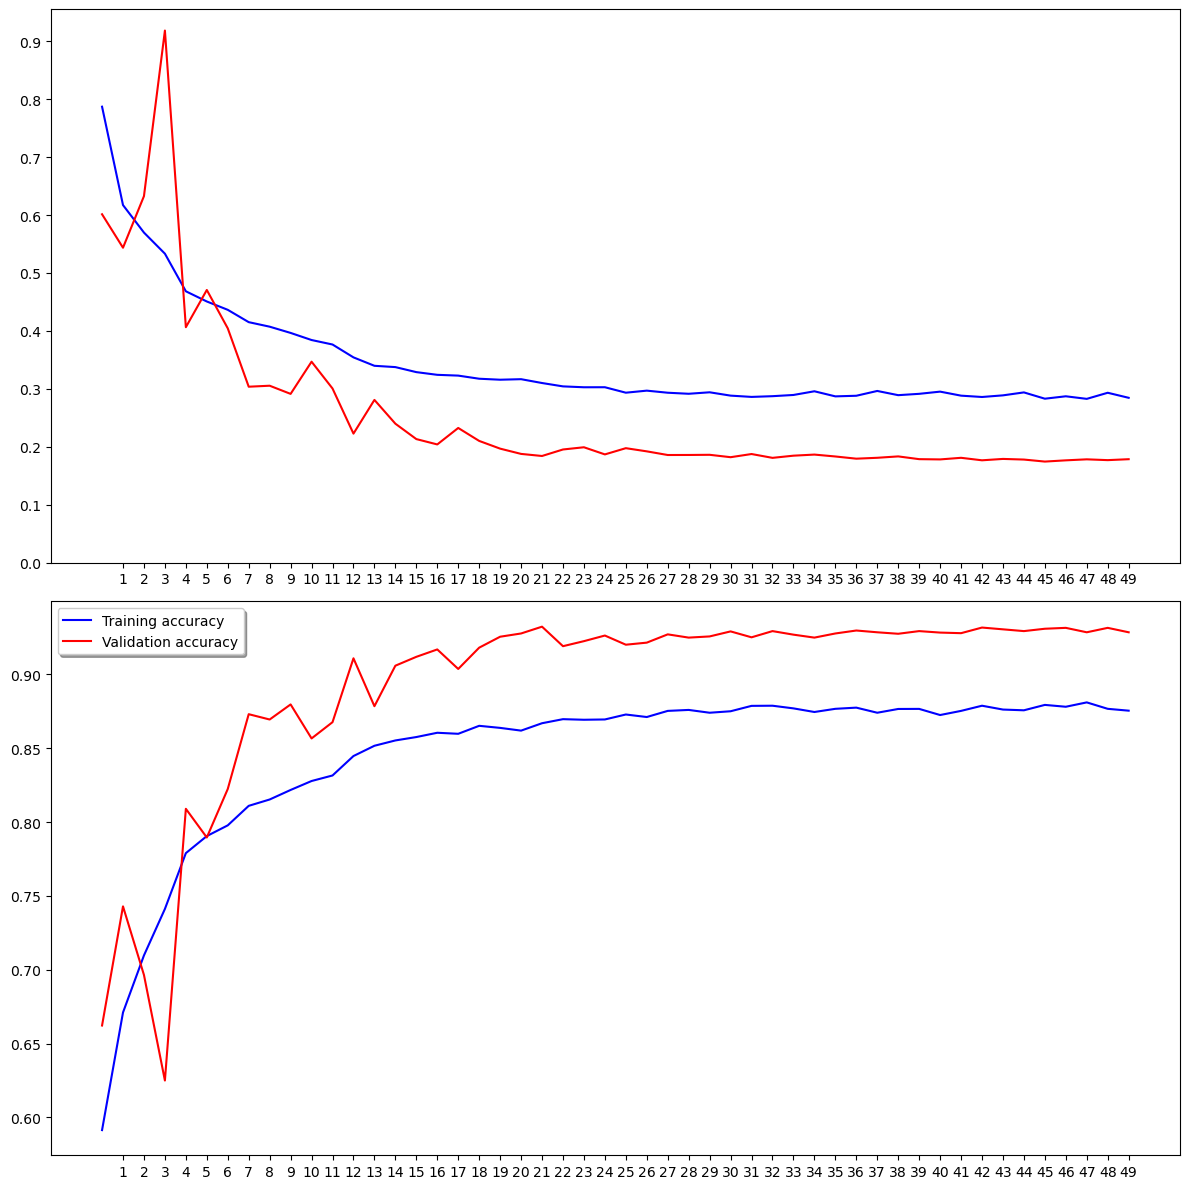

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [30]:
test_filenames = os.listdir("./data/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [32]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./data/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [34]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

834/834 [==============================] - 104s 125ms/step


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

In [44]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [45]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<Axes: xlabel='category'>

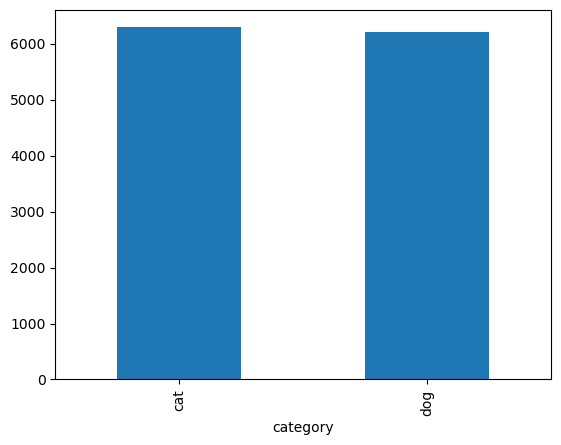

In [46]:
test_df['category'].value_counts().plot.bar()


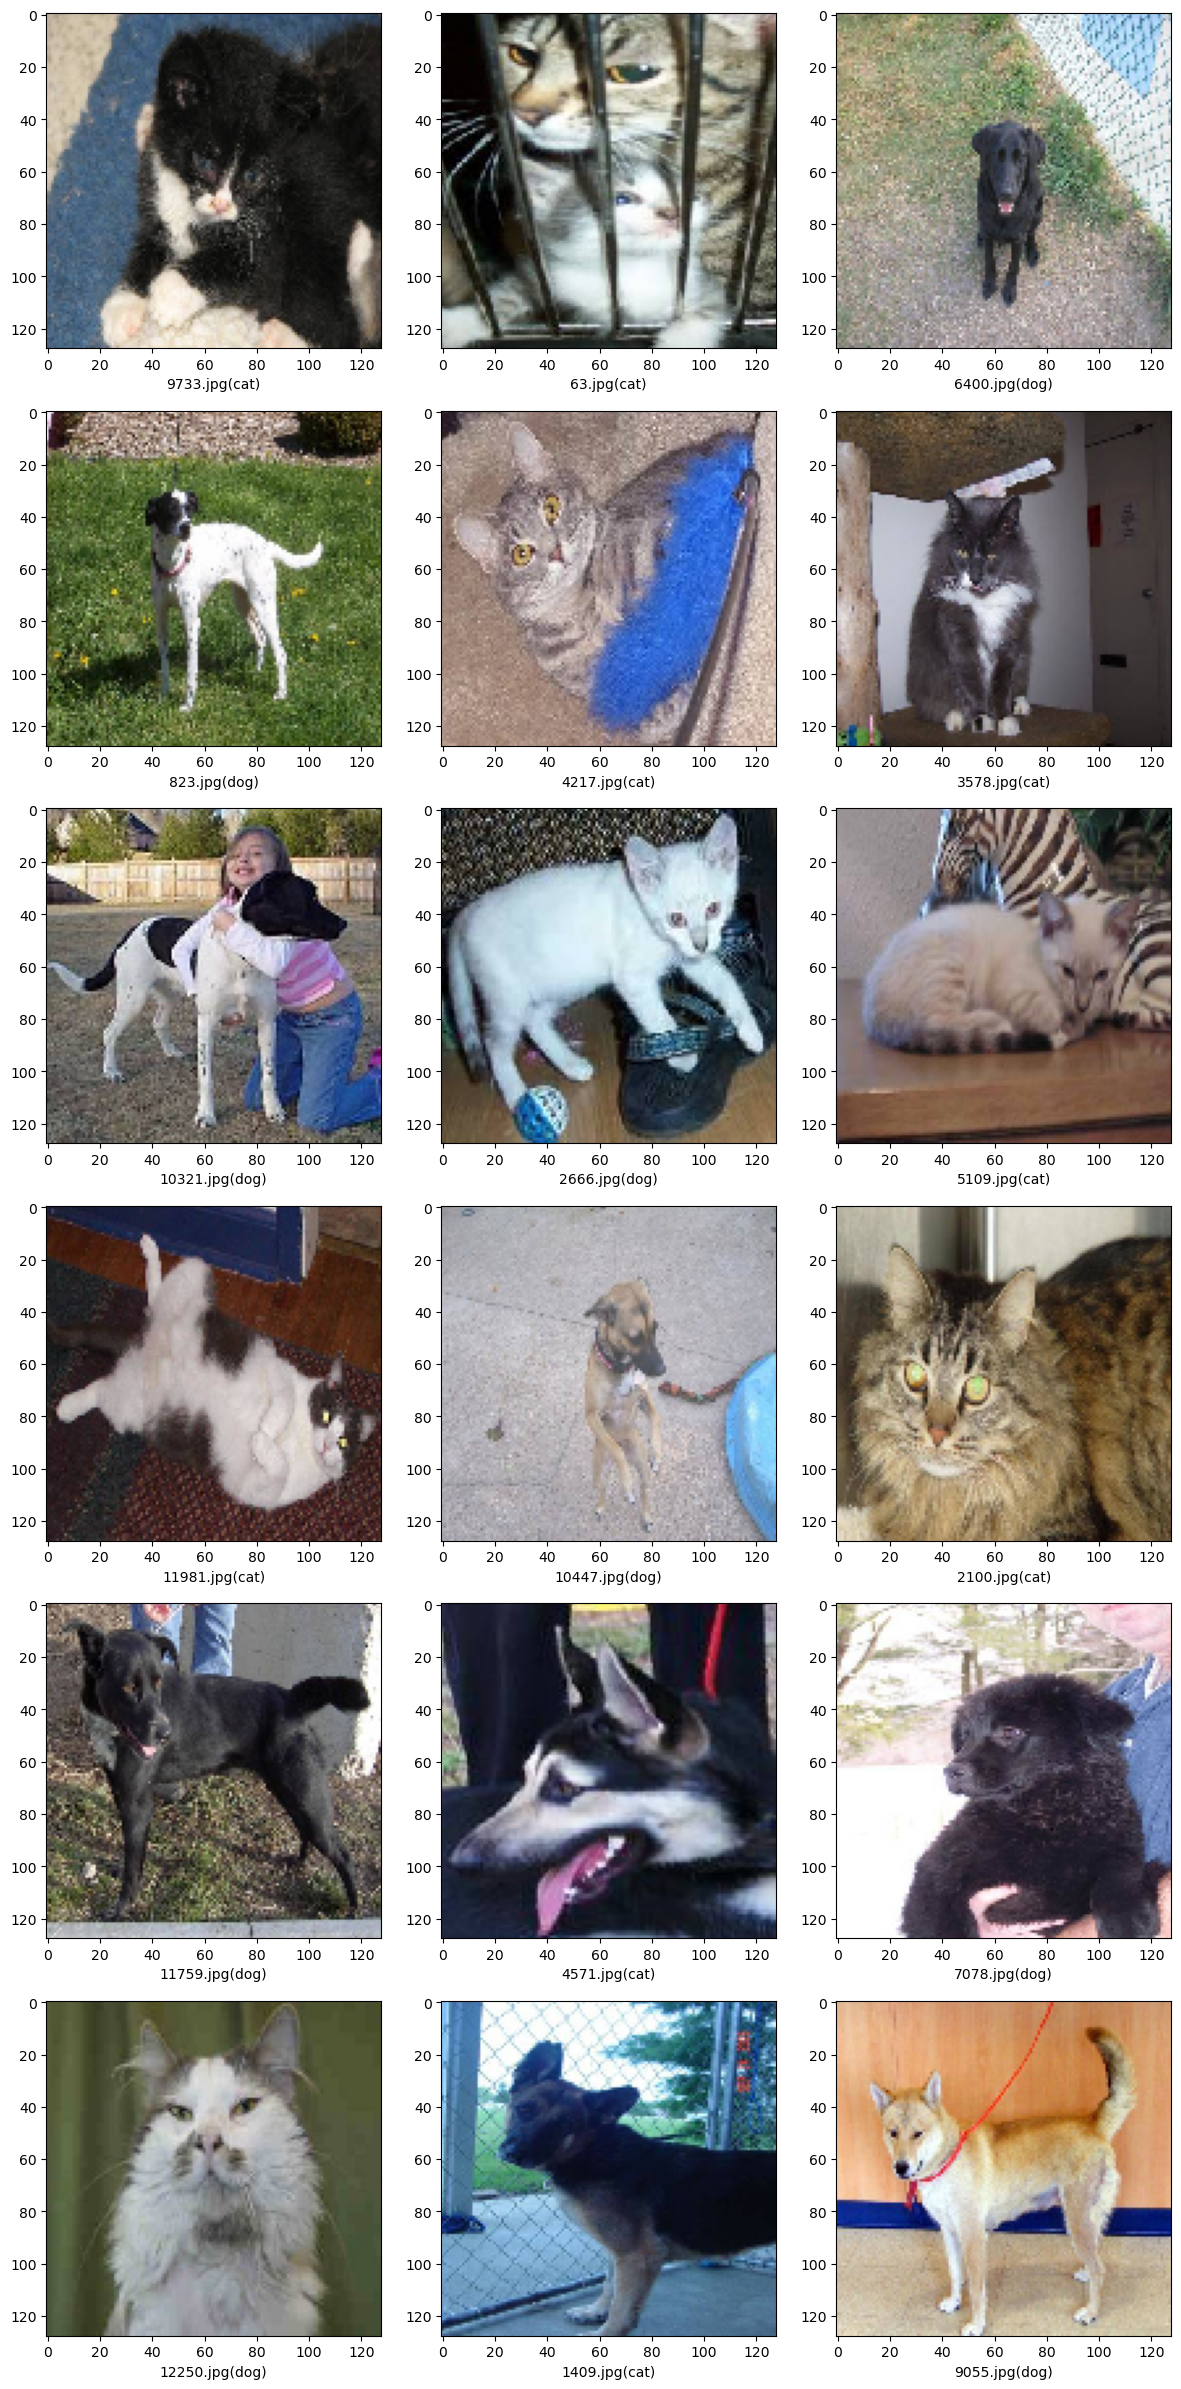

In [47]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


In [48]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)